In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice
from functions_geom_DIB import geom_DIB_on_alternatives

In [2]:
# Load data
data = pd.read_csv('../data/swissmetro.dat', sep='\t')

In [3]:
# Display every columns of the dataset
pd.set_option('display.max_columns', None)
data

,ID,SURVEY,PURPOSE,FIRST,TICKET,WHO,LUGGAGE,S_O_P,AGE,MALE,INCOME,GA,ORIGIN,DEST,TRAIN_AV,CAR_AV,SM_AV,TRAIN_TT,TRAIN_CO,TRAIN_FR,SM_TT,SM_CO,SM_FR,SM_SEATS,CAR_TT,CAR_CO,CHOICE
0,1,0,1,0,1,1,0,2,3,0,2,0,2,1,1,1,1,112,48,120,63,52,20,0,117,65,2
1,1,0,1,0,1,1,0,2,3,0,2,0,2,1,1,1,1,103,48,30,60,49,10,0,117,84,2
2,1,0,1,0,1,1,0,2,3,0,2,0,2,1,1,1,1,130,48,60,67,58,30,0,117,52,2
3,1,0,1,0,1,1,0,2,3,0,2,0,2,1,1,1,1,103,40,30,63,52,20,0,72,52,2
4,1,0,1,0,1,1,0,2,3,0,2,0,2,1,1,1,1,130,36,60,63,42,20,0,90,84,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10705,1190,1,4,1,7,1,0,2,5,1,3,0,2,20,1,1,1,148,13,30,93,17,30,0,156,56,2
10706,1190,1,4,1,7,1,0,2,5,1,3,0,2,20,1,1,1,148,12,30,96,16,10,0,96,70,3
10707,1190,1,4,1,7,1,0,2,5,1,3,0,2,20,1,1,1,148,16,60,93,16,20,0,96,56,3
10708,1190,1,4,1,7,1,0,2,5,1,3,0,2,20,1,1,1,178,16,30,96,17,30,0,96,91,2


In [4]:
data_used = data[['ID', 'TRAIN_TT', 'SM_TT', 'CAR_TT', 'TRAIN_CO', 'SM_CO', 'CAR_CO',
                   'TRAIN_AV', 'SM_AV', 'CAR_AV', 'GA', 'CHOICE']]

In [22]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_SM", "ASC_CAR", "BETA_TT", "BETA_CO"]

# DEFINE MODEL STRUCTURE AND LIKELIHOOD FUNCTION
def log_likelihood_SM_LM(beta, data):
    # Define utility functions
    data['U_TRAIN'] = beta[2] * data['TRAIN_TT'] + beta[3] * (data['GA'] == 0) * data['TRAIN_CO']
    data['U_SM'] = beta[0] + beta[2] * data['SM_TT'] + beta[3] * (data['GA'] == 0) * data['SM_CO']
    data['U_CAR'] = beta[1] + beta[2] * data['CAR_TT'] + beta[3] * data['CAR_CO']

    sum_total = data['TRAIN_AV'] * np.exp(data['U_TRAIN']) + data['SM_AV'] * np.exp(data['U_SM']) + \
                data['CAR_AV'] * np.exp(data['U_CAR'])
    
    # Full probabilities
    data['P_TRAIN_1'] = np.exp(data['U_TRAIN']) / sum_total
    data['P_SM_2'] = np.exp(data['U_SM']) / sum_total
    data['P_CAR_3'] = np.exp(data['U_CAR']) / sum_total
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['CHOICE'] == 1) * data['P_TRAIN_1'] + \
                (data['CHOICE'] == 2) * data['P_SM_2'] + \
                (data['CHOICE'] == 3) * data['P_CAR_3']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data.loc[data['P'] == 0, 'P'] = epsilon
    
    # Calculate log-likelihood 
    LL = data.groupby('ID')['P'].prod().apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [23]:
# Define model parameters
beta = np.array([0, 0, 0, 0])
beta_names = ["ASC_SM", "ASC_CAR", "BETA_TT", "BETA_CO"]

# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data_used, beta, beta_names, log_likelihood_SM_LM)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_6759/357049094.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_TRAIN'] = beta[2] * data['TRAIN_TT'] + beta[3] * (data['GA'] == 0) * data['TRAIN_CO']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_6759/357049094.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_SM'] = beta[0] + beta[2] * data['SM_TT'] + beta[3] * (data['GA'] == 0) * data['SM_CO']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_6759/3570490

Optimization Results:
  Parameter  Estimate  Robust Asymptotic SE  t-statistic   p-value
0    ASC_SM  0.655274              0.155548     4.212688  0.000025
1   ASC_CAR  0.667142              0.005898   113.116901  0.000000
2   BETA_TT -0.012750              0.000815   -15.640170  0.000000
3   BETA_CO -0.007934              0.005884    -1.348313  0.177586
AIC: 17334.127978248634
BIC: 17363.243710902403
Log-likelihood: -8663.063989124317


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_6759/357049094.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['P_CAR_3'] = np.exp(data['U_CAR']) / sum_total
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_6759/357049094.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['P'] = (data['CHOICE'] == 1) * data['P_TRAIN_1'] + \
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_6759/357049094.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [24]:
df_input = data[['TRAIN_TT', 'SM_TT', 'CAR_TT', 'TRAIN_CO', 'SM_CO', 'CAR_CO',
                  'TRAIN_AV', 'SM_AV', 'CAR_AV', 'GA']]
# Calculate frequencies and probabilities
vector_counts = df_input.value_counts().reset_index(name='Frequency')
vector_counts['Probability'] = vector_counts['Frequency'] / len(df_input)

# Creating a tuple of attributes to facilitate mapping
vector_counts['tuple'] = vector_counts[['TRAIN_TT', 'SM_TT', 'CAR_TT', 'TRAIN_CO', 'SM_CO', 'CAR_CO',
                                        'TRAIN_AV', 'SM_AV', 'CAR_AV', 'GA']].apply(tuple, axis=1)
probability_map = vector_counts.set_index('tuple')['Probability'].to_dict()

# Assign the probability to each row based on its tuple of attributes
df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_6759/1669296022.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


In [25]:
# Computation of p(x,y)
p_x = df_input['Probability'].values

p_y_given_x = data_used[['P_TRAIN_1', 'P_SM_2', 'P_CAR_3']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [26]:
def simulate_choice_SM(row):
    """
    Function to simulate a choice based on cumulative probabilities.

    Parameters:
    - row: pandas Series or DataFrame row containing probabilities for each choice

    Returns:
    - The simulated choice (an integer between 1 and the number of choices)
    """
    # Generate a random number between 0 and 1
    random_number = np.random.rand()
    
    # Calculate cumulative probabilities
    probabilities = row[['P_TRAIN_1', 'P_SM_2', 'P_CAR_3']]
    cumulative_probs = probabilities.cumsum()
    
    # Determine simulated choice based on random number
    for i, cumulative_prob in enumerate(cumulative_probs):
        if random_number <= cumulative_prob:
            return i+1

In [27]:
np.random.seed(123)
data_used['simulated_choice'] = data_used.apply(simulate_choice_SM, axis=1)
data_used

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_6759/1325199898.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['simulated_choice'] = data_used.apply(simulate_choice_SM, axis=1)


,ID,TRAIN_TT,SM_TT,CAR_TT,TRAIN_CO,SM_CO,CAR_CO,TRAIN_AV,SM_AV,CAR_AV,GA,CHOICE,U_TRAIN,U_SM,U_CAR,P_TRAIN_1,P_SM_2,P_CAR_3,P,simulated_choice,cluster,max_proba
0,1,112,63,117,48,52,65,1,1,1,0,2,-1.808794,-0.560524,-1.340280,0.164421,0.572896,0.262683,0.572896,2,0,2
1,1,103,60,117,48,49,84,1,1,1,0,2,-1.694047,-0.498473,-1.491027,0.180814,0.597672,0.221514,0.597672,2,0,2
2,1,130,67,117,48,58,52,1,1,1,0,2,-2.038288,-0.659127,-1.237137,0.138895,0.551632,0.309473,0.551632,2,0,2
3,1,103,63,72,40,52,52,1,1,1,0,2,-1.630575,-0.560524,-0.663403,0.152764,0.445389,0.401846,0.445389,2,0,2
4,1,130,63,90,36,42,84,1,1,1,0,2,-1.943079,-0.481183,-1.146786,0.132777,0.572816,0.294407,0.572816,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10705,1190,148,93,156,13,17,56,1,1,1,0,2,-1.990089,-0.665321,-1.766109,0.166324,0.625597,0.208079,0.625597,2,0,2
10706,1190,148,96,96,12,16,70,1,1,1,0,3,-1.982155,-0.695636,-1.112207,0.142715,0.516653,0.340631,0.340631,2,0,2
10707,1190,148,93,96,16,16,56,1,1,1,0,3,-2.013892,-0.657387,-1.001131,0.130962,0.508474,0.360564,0.360564,3,0,2
10708,1190,178,96,96,16,17,91,1,1,1,0,2,-2.396381,-0.703570,-1.278823,0.105351,0.572553,0.322097,0.572553,3,0,2


Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

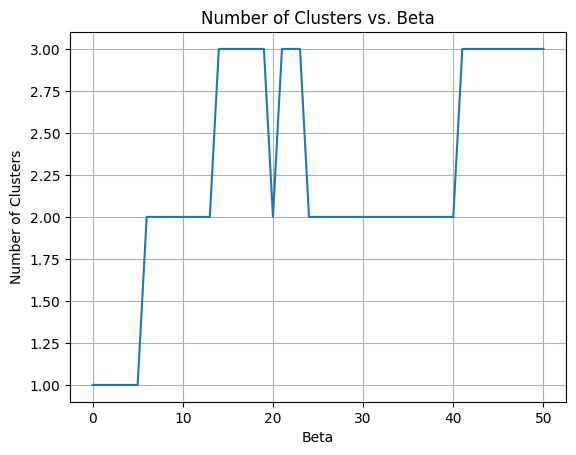

In [37]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-3)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [53]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=500, max_iter=5000, threshold=1e-4)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000


In [54]:
import re

# Define a function to extract the number from the column name
def extract_number(column_name):
    match = re.search(r'\d+', column_name)  # Search for one or more digits in the column name
    if match:
        return int(match.group())  # Return the first occurrence of digits as an integer
    else:
        return None  # Return None if no digits are found

In [55]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data_used['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data_used.groupby(['cluster', 'CHOICE']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data_used['max_proba'] = data_used[['P_TRAIN_1', 'P_SM_2', 'P_CAR_3']].idxmax(axis=1).apply(extract_number)
cluster_counts2 = data_used.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data_used.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 3

 cluster
0    6844
2    3257
1     609
Name: count, dtype: int64

 CHOICE     1     2     3
cluster                 
0        659  4560  1625
1        164   368    77
2        600  1285  1372

 max_proba     2     3
cluster              
0          6761    83
1             0   609
2            81  3176

 simulated_choice    1     2     3
cluster                          
0                 840  4222  1782
1                 106   346   157
2                 470  1661  1126


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_6759/745230889.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_6759/745230889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['max_proba'] = data_used[['P_TRAIN_1', 'P_SM_2', 'P_CAR_3']].idxmax(axis=1).apply(extract_number)
